Dataset Shape: (1278, 17)

Column Names and Types:
student_id                object
district_name             object
campus_name               object
grad_cohort                int64
gender                    object
ecodis                    object
sped                      object
ell                       object
pct_absences               int64
dual_credit_attempt       object
dual_credit_complete      object
cte_concentrator          object
industry_credential_hs    object
tsia_math_ready           object
tsia_reading_ready        object
sat_act_college_ready     object
ems_touchpoints            int64
dtype: object

First few rows:
  student_id  district_name   campus_name  grad_cohort gender ecodis sped ell  \
0      S0001  Northview ISD  Northview HS         2020      M      N    N   N   
1      S0002  Northview ISD  Northview HS         2020      M      N    Y   N   
2      S0003  Northview ISD  Northview HS         2020      M      Y    N   N   
3      S0004  Northview ISD  Nort

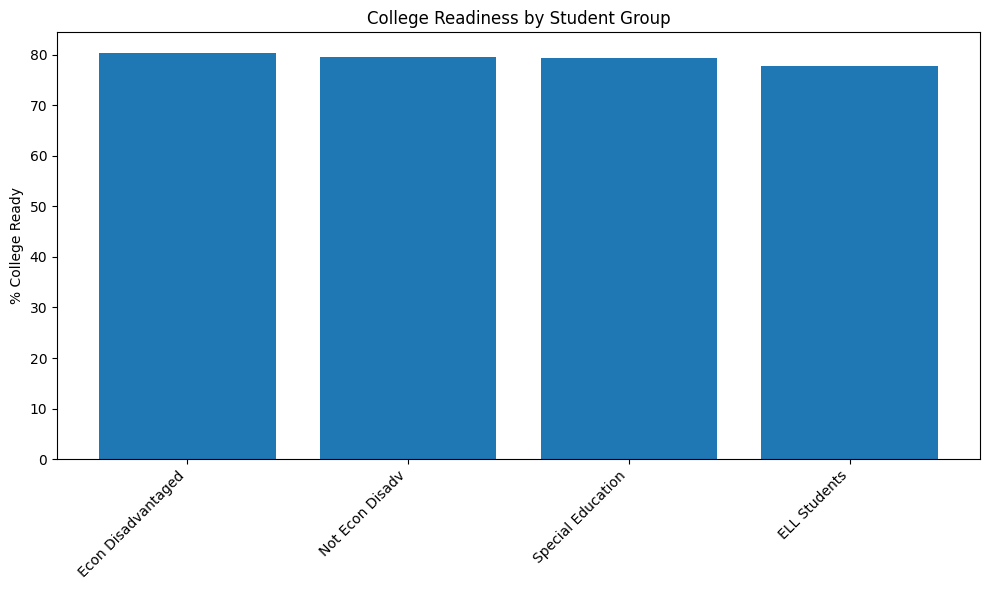


District Comparison:
               Students  Pct_EcoDis  Pct_DC_Attempt  Pct_DC_Complete  Pct_CTE  \
district_name                                                                   
Lakeview ISD        415        58.1            53.0             37.8     36.6   
Northview ISD       426        32.6            52.3             36.4     40.1   
Riverbend ISD       437        74.4            48.1             31.4     37.5   

               Pct_Ready  Avg_EMS  Avg_Absence  
district_name                                   
Lakeview ISD        78.8    2.957        7.549  
Northview ISD       80.3    2.960        7.411  
Riverbend ISD       81.0    3.146        7.579  

Grad Cohort Trends:
             student_id  dual_credit_attempted  dual_credit_completed  \
grad_cohort                                                             
2020              21900                   54.3                   36.1   
2021              21900                   53.9                   37.9   
2022          

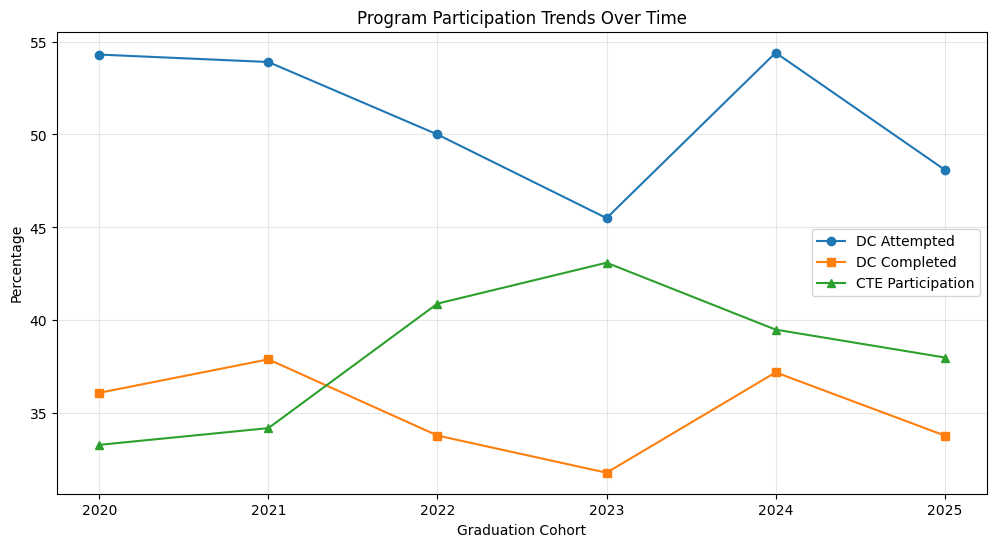

<ipython-input-14-a605c15a6668>:190: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ems_analysis = cleaned_df.groupby('ems_level').agg({



EMS Support Level Analysis:
               student_id  is_ecodis  dual_credit_attempted  \
ems_level                                                     
0 touchpoints         171      0.544                  0.544   
1-2                   366      0.552                  0.527   
3-4                   377      0.560                  0.501   
5+                    364      0.547                  0.489   

               dual_credit_completed  any_college_ready  pct_absences  
ems_level                                                              
0 touchpoints                  0.339              0.795         7.497  
1-2                            0.369              0.790         7.587  
3-4                            0.350              0.817         7.592  
5+                             0.341              0.797         7.365  


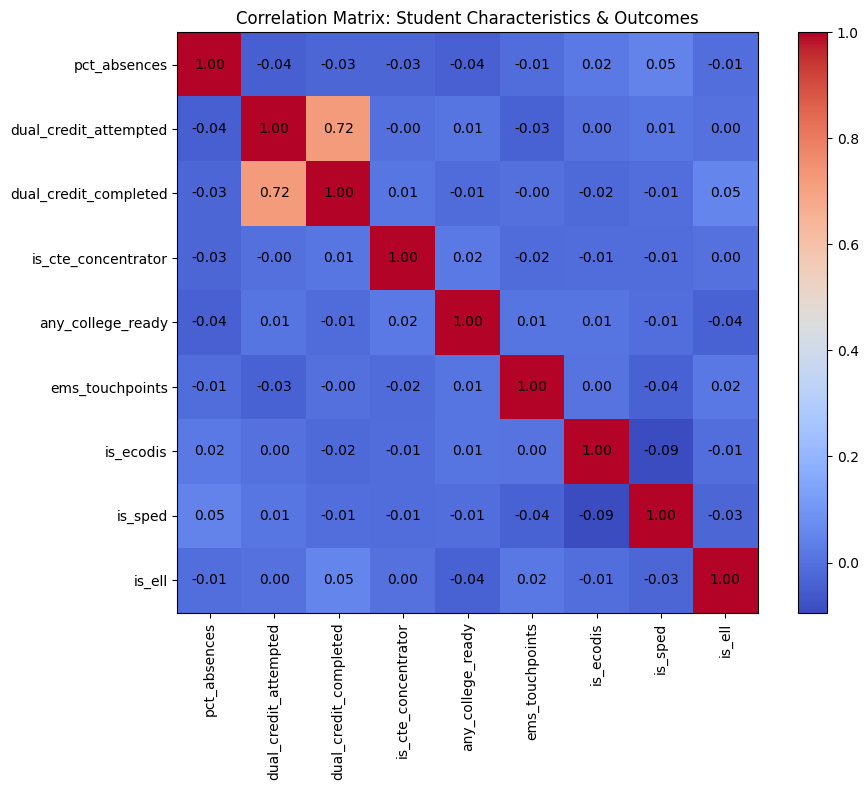

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("district_participation_readiness.csv")
print("Dataset Shape:", df.shape)
print("\nColumn Names and Types:")
print(df.dtypes)
print("\nFirst few rows:")
print(df.head())

print("\nMissing Values:")
print(df.isnull().sum())
print("\nMissing Value Percentages:")
print((df.isnull().sum() / len(df)) * 100)

columns_to_check = [
    'student_id', 'district_name', 'gender', 'ecodis', 'sped', 'ell',
    'pct_absences', 'dual_credit_attempt', 'dual_credit_complete',
    'cte_concentrator', 'industry_credential_hs', 'tsia_math_ready',
    'tsia_reading_ready', 'sat_act_college_ready', 'ems_touchpoints'
]

results = []

for col in columns_to_check:
    null_count = df[col].isna().sum()
    null_percentage = round(100 * null_count / len(df), 2)
    results.append((col, null_count, null_percentage))

null_summary = pd.DataFrame(results, columns=['column_name', 'null_count', 'null_percentage'])

null_summary = null_summary.sort_values(by='null_count', ascending=False).reset_index(drop=True)

null_summary


print("\nNumeric Column Summary:")
print(df.describe())

categorical_cols = ['gender', 'ecodis', 'sped', 'ell', 'dual_credit_attempt', 'dual_credit_complete', 'cte_concentrator']

for col in categorical_cols:
    print(f"\n{col} unique values:")
    print(df[col].value_counts())
cleaned_df = df.copy()

yn_columns = {
    'ecodis': 'is_ecodis',
    'sped': 'is_sped',
    'ell': 'is_ell',
    'dual_credit_attempt': 'dual_credit_attempted',
    'dual_credit_complete': 'dual_credit_completed',
    'cte_concentrator': 'is_cte_concentrator',
    'industry_credential_hs': 'earned_industry_credential',
    'tsia_math_ready': 'tsia_math_ready',
    'tsia_reading_ready': 'tsia_reading_ready',
    'sat_act_college_ready': 'sat_act_ready'
}

for old_col, new_col in yn_columns.items():
    cleaned_df[new_col] = np.where(cleaned_df[old_col] == 'Y', 1, 0)

cleaned_df['any_college_ready'] = np.where(
    (cleaned_df['tsia_math_ready'] == 1) | 
    (cleaned_df['tsia_reading_ready'] == 1) | 
    (cleaned_df['sat_act_ready'] == 1),
    1, 0
)

cleaned_df['fully_college_ready'] = np.where(
    (cleaned_df['tsia_math_ready'] == 1) & 
    (cleaned_df['tsia_reading_ready'] == 1) & 
    (cleaned_df['sat_act_ready'] == 1),
    1, 0
)

cleaned_df['chronically_absent'] = np.where(
    cleaned_df['pct_absences'] > 10, 1, 0
)

print("Data transformation complete!")
print(f"New columns created: {list(yn_columns.values())}")

def analyze_group(dataframe, group_name, filter_condition=None):
    """
    Helper function to analyze outcomes for a specific group
    """
    if filter_condition is not None:
        subset = dataframe[filter_condition]
    else:
        subset = dataframe
    
    return {
        'group': group_name,
        'n_students': len(subset),
        'pct_dual_credit_attempt': subset['dual_credit_attempted'].mean() * 100,
        'pct_dual_credit_complete': subset['dual_credit_completed'].mean() * 100,
        'pct_cte': subset['is_cte_concentrator'].mean() * 100,
        'pct_credential': subset['earned_industry_credential'].mean() * 100,
        'pct_any_ready': subset['any_college_ready'].mean() * 100,
        'pct_fully_ready': subset['fully_college_ready'].mean() * 100,
        'avg_ems': subset['ems_touchpoints'].mean(),
        'pct_chronic_absent': subset['chronically_absent'].mean() * 100
    }

results = []
results.append(analyze_group(cleaned_df, 'Econ Disadvantaged', 
                             cleaned_df['is_ecodis'] == 1))
results.append(analyze_group(cleaned_df, 'Not Econ Disadv', 
                             cleaned_df['is_ecodis'] == 0))
results.append(analyze_group(cleaned_df, 'Special Education', 
                             cleaned_df['is_sped'] == 1))
results.append(analyze_group(cleaned_df, 'ELL Students', 
                             cleaned_df['is_ell'] == 1))

equity_df = pd.DataFrame(results)
print(equity_df.round(1))

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

groups = equity_df['group']
values = equity_df['pct_any_ready']

x_positions = np.arange(len(groups))
plt.bar(x_positions, values)

plt.xticks(x_positions, groups, rotation=45, ha='right')
plt.ylabel('% College Ready')
plt.title('College Readiness by Student Group')
plt.tight_layout()
plt.show()



district_summary = cleaned_df.groupby('district_name').agg({
    'student_id': 'count',  # Count of students
    'is_ecodis': 'mean',    # % economically disadvantaged
    'dual_credit_attempted': 'mean',
    'dual_credit_completed': 'mean',
    'is_cte_concentrator': 'mean',
    'any_college_ready': 'mean',
    'ems_touchpoints': 'mean',
    'pct_absences': 'mean'
}).round(3)

district_summary.columns = ['Students', 'Pct_EcoDis', 'Pct_DC_Attempt',
                           'Pct_DC_Complete', 'Pct_CTE', 'Pct_Ready',
                           'Avg_EMS', 'Avg_Absence']

for col in ['Pct_EcoDis', 'Pct_DC_Attempt', 'Pct_DC_Complete', 'Pct_CTE', 'Pct_Ready']:
    district_summary[col] = district_summary[col] * 100

print("\nDistrict Comparison:")
print(district_summary)

cohort_trends = cleaned_df.groupby('grad_cohort').agg({
    'student_id': 'count',
    'dual_credit_attempted': 'mean',
    'dual_credit_completed': 'mean',
    'is_cte_concentrator': 'mean',
    'earned_industry_credential': 'mean',
    'any_college_ready': 'mean',
    'chronically_absent': 'mean'
}).round(3) * 100 

print("\nGrad Cohort Trends:")
print(cohort_trends)

plt.figure(figsize=(12, 6))
plt.plot(cohort_trends.index, cohort_trends['dual_credit_attempted'], 
         marker='o', label='DC Attempted')
plt.plot(cohort_trends.index, cohort_trends['dual_credit_completed'], 
         marker='s', label='DC Completed')
plt.plot(cohort_trends.index, cohort_trends['is_cte_concentrator'], 
         marker='^', label='CTE Participation')
plt.xlabel('Graduation Cohort')
plt.ylabel('Percentage')
plt.title('Program Participation Trends Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

cleaned_df['ems_level'] = pd.cut(cleaned_df['ems_touchpoints'],
                                bins=[-1, 0, 2, 4, 100],
                                labels=['0 touchpoints', '1-2', '3-4', '5+'])

ems_analysis = cleaned_df.groupby('ems_level').agg({
    'student_id': 'count',
    'is_ecodis': 'mean',
    'dual_credit_attempted': 'mean',
    'dual_credit_completed': 'mean',
    'any_college_ready': 'mean',
    'pct_absences': 'mean'
}).round(3)

print("\nEMS Support Level Analysis:")
print(ems_analysis)

numeric_cols = ['pct_absences', 'dual_credit_attempted', 'dual_credit_completed',
                'is_cte_concentrator', 'any_college_ready', 'ems_touchpoints',
                'is_ecodis', 'is_sped', 'is_ell']

correlation_matrix = cleaned_df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Correlation Matrix: Student Characteristics & Outcomes')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)

for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j, i, 
                 f"{correlation_matrix.iloc[i, j]:.2f}",
                 ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

